In [73]:
import georinex as gr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import RectBivariateSpline
from matplotlib.ticker import MaxNLocator

def moving_average(arr, window_size=50):
    padded_arr = np.pad(arr, (window_size // 2, window_size // 2), mode='edge')
    cumsum = np.cumsum(padded_arr)
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return moving_avg

def normalize_amplitude_timeseries(data):
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)

    normalized_data = (data - np.nanmean(data))/(max_val - min_val)

    return normalized_data

def get_common_sv_list(obs_short,obs_medium,obs_long):
    sv_list_short = obs_short.sv.values
    sv_list_medium = obs_medium.sv.values
    sv_list_long = obs_long.sv.values

    sv_list = [sv for sv in sv_list_long if sv in sv_list_short and sv in sv_list_medium]

    return sv_list 

def get_spectrogram_all_bands(obs,sv,use='G',normalize=True,use_moving_average=True,window_size=14,window='blackmanharris',nperseg=1300,nfft=2400,noverlap=1200,spectrum='spectrum',mode='psd'):
    CN0_L1_SELECTOR = 'S1C'
    CN0_L2_SELECTOR = 'S2L'
    CN0_L5_SELECTOR = 'S5Q'
    CN0_E1_SELECTOR = "S1C"
    CN0_E5A_SELECTOR = "S5Q"
    CN0_E5B_SELECTOR = "S7Q"
    CN0_E5AB_SELECTOR = "S8Q"

    if use=='G':
        L1_cn0 = obs.sel(sv=sv)[CN0_L1_SELECTOR]
        L2_cn0 = obs.sel(sv=sv)[CN0_L2_SELECTOR]
        L5_cn0 = obs.sel(sv=sv)[CN0_L5_SELECTOR]

        if normalize:
            L1_cn0 = normalize_amplitude_timeseries(L1_cn0)
            L2_cn0 = normalize_amplitude_timeseries(L2_cn0)
            L5_cn0 = normalize_amplitude_timeseries(L5_cn0)
        if use_moving_average:
            L1_cn0 = moving_average(L1_cn0,window_size=window_size)
            L2_cn0 = moving_average(L2_cn0,window_size=window_size)
            L5_cn0 = moving_average(L5_cn0,window_size=window_size)

        f, t, Sxx_L1 = signal.spectrogram(L1_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        _, _, Sxx_L2 = signal.spectrogram(L2_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        _, _, Sxx_L5 = signal.spectrogram(L5_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        return f, t, Sxx_L1, Sxx_L2, Sxx_L5
    
    elif use=='E':
        E1_cn0 = obs.sel(sv=sv)[CN0_E1_SELECTOR]
        E5a_cn0 = obs.sel(sv=sv)[CN0_E5A_SELECTOR]
        E5b_cn0 = obs.sel(sv=sv)[CN0_E5B_SELECTOR]
        E5ab_cn0 = obs.sel(sv=sv)[CN0_E5AB_SELECTOR]

        if normalize:
            E1_cn0 = normalize_amplitude_timeseries(E1_cn0)
            E5a_cn0 = normalize_amplitude_timeseries(E5a_cn0)
            E5b_cn0 = normalize_amplitude_timeseries(E5b_cn0)
            E5ab_cn0 = normalize_amplitude_timeseries(E5ab_cn0)
        if moving_average:
            E1_cn0 = moving_average(E1_cn0,window_size=window_size)
            E5a_cn0 = moving_average(E5a_cn0,window_size=window_size)
            E5b_cn0 = moving_average(E5b_cn0,window_size=window_size)
            E5ab_cn0 = moving_average(E5ab_cn0,window_size=window_size)

        f, t, Sxx_E1 = signal.spectrogram(E1_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        _, _, Sxx_E5a = signal.spectrogram(E5a_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        _, _, Sxx_E5b = signal.spectrogram(E5b_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        _, _, Sxx_E5ab = signal.spectrogram(E5ab_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        return f, t, Sxx_E1, Sxx_E5a, Sxx_E5b, Sxx_E5ab

def plot_image_with_max(rgb_image, ax, title, find_max=False, interpolate=False, print_max=False):
    if interpolate:
        scale_factor = 4
        rgb_image = interpolate_image(rgb_image,scale_factor)
    ax.imshow(rgb_image)
    if find_max:
        rgb_sum = np.sum(rgb_image, axis=2)
        max_value = np.max(rgb_sum)
        if max_value >= 1:
            max_idx = np.unravel_index(np.argmax(rgb_sum), rgb_sum.shape)
            ax.scatter(max_idx[1], max_idx[0], s=75, alpha=0.9, color='white', marker='o', facecolors='none')
    ax.invert_yaxis()
    ax.set_title(title,fontsize=14)
    
def interpolate_image(image, scale_factor):
    # Get the dimensions of the original image
    height, width, channels = image.shape
    
    # Define the new dimensions after scaling
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)
    
    # Generate the indices for the new image
    x_new = np.linspace(0, width - 1, new_width)
    y_new = np.linspace(0, height - 1, new_height)
    
    # Generate the grid for the interpolation
    x_old = np.arange(width)
    y_old = np.arange(height)
    
    # Perform bilinear interpolation for each channel
    interpolated_image = np.zeros((new_height, new_width, channels))
    for c in range(channels):
        interpolator = RectBivariateSpline(y_old, x_old, image[:,:,c])
        interpolated_channel = interpolator(y_new, x_new)

        # Normalize the interpolated channel to match the original image's range
        min_val = np.min(image[:,:,c])
        max_val = np.max(image[:,:,c])
         
        interpolated_channel = (interpolated_channel - np.min(interpolated_channel)) * (max_val - min_val) / (np.max(interpolated_channel) - np.min(interpolated_channel)) + min_val
        
        interpolated_image[:,:,c] = interpolated_channel
    
    return interpolated_image

In [85]:
use = 'E'
NORMALIZE_EVERYTHING = False
NORMALIZE_PER_IMAGE = False
NORMALIZE_PER_MATERIAL = True

USE_DISTANCE_IMAGES = True # if set to False, it will make frequency images

interesting_sv_metal_gps = 'G28' 
interesting_sv_glass_gps = 'G26'
interesting_sv_brick_gps = 'G11'

interesting_sv_metal_gal = 'E24' # E24 E05 E03
interesting_sv_glass_gal = 'E30' # E27 E30 good candidates
interesting_sv_brick_gal = 'E11'

if use == 'G':
    interesting_sv_metal = interesting_sv_metal_gps
    interesting_sv_brick = interesting_sv_brick_gps
    interesting_sv_glass = interesting_sv_glass_gps
elif use == 'E':
    interesting_sv_metal = interesting_sv_metal_gal
    interesting_sv_brick = interesting_sv_brick_gal
    interesting_sv_glass = interesting_sv_glass_gal

materials = ["brick", "metal", "glass"]
distances = ["short", "medium", "long"]
if use == 'G':
    frequencies = ["L1", "L2", "L5"]
elif use == 'E':
    frequencies = ["E1", "E5a", "E5b", "E5ab"]

In [75]:
path_metal = f'../Data/metal_wall/distance_correlations/'
path_glass = f'../Data/glass_wall/distance_correlations/'
path_brick = f'../Data/brick_wall/distance_correlations/'

metal_date = f'020524'
metal_short = f'{metal_date}/3631751_metal_diff_distance_2.5m'
metal_medium = f'{metal_date}/3632777_metal_diff_distance_5m'
metal_long = f'{metal_date}/3633416_metal_diff_distance_10m'

brick_date = f'210424'
brick_short = f'{brick_date}/3631751_brick_diff_dist_2.5m'
brick_medium = f'{brick_date}/3633416_brick_diff_dist_5m'
brick_long = f'{brick_date}/3632777_brick_diff_dist_10m'

glass_date = f'210424'
glass_short = f'{glass_date}/3631751_glass_diff_dist_2.5m'
glass_medium = f'{glass_date}/3632777_glass_diff_dist_5m'
glass_long = f'{glass_date}/3633416_glass_diff_dist_10m'

if use == 'G':
    nav = f'_gps.nav'
elif use == 'E':
    nav = f'_galileo.nav'

obs_metal_short = gr.load(f'{path_metal}{metal_short}.obs',use=use)
obs_metal_medium = gr.load(f'{path_metal}{metal_medium}.obs',use=use)
obs_metal_long = gr.load(f'{path_metal}{metal_long}.obs',use=use)

obs_brick_short = gr.load(f'{path_brick}{brick_short}.obs',use=use)
obs_brick_medium = gr.load(f'{path_brick}{brick_medium}.obs',use=use)
obs_brick_long = gr.load(f'{path_brick}{brick_long}.obs',use=use)

obs_glass_short = gr.load(f'{path_glass}{glass_short}.obs',use=use)
obs_glass_medium = gr.load(f'{path_glass}{glass_medium}.obs',use=use)
obs_glass_long = gr.load(f'{path_glass}{glass_long}.obs',use=use)


In [86]:
if use == 'G':
    f_brick_short, t_brick_short, Sxx_L1_brick_short, Sxx_L2_brick_short, Sxx_L5_brick_short = get_spectrogram_all_bands(obs_brick_short, interesting_sv_brick, use=use)
    f_brick_medium, t_brick_medium, Sxx_L1_brick_medium, Sxx_L2_brick_medium, Sxx_L5_brick_medium = get_spectrogram_all_bands(obs_brick_medium, interesting_sv_brick, use=use)
    f_brick_long, t_brick_long, Sxx_L1_brick_long, Sxx_L2_brick_long, Sxx_L5_brick_long = get_spectrogram_all_bands(obs_brick_long, interesting_sv_brick, use=use)

    f_metal_short, t_metal_short, Sxx_L1_metal_short, Sxx_L2_metal_short, Sxx_L5_metal_short = get_spectrogram_all_bands(obs_metal_short, interesting_sv_metal, use=use)
    f_metal_medium, t_metal_medium, Sxx_L1_metal_medium, Sxx_L2_metal_medium, Sxx_L5_metal_medium = get_spectrogram_all_bands(obs_metal_medium, interesting_sv_metal, use=use)
    f_metal_long, t_metal_long, Sxx_L1_metal_long, Sxx_L2_metal_long, Sxx_L5_metal_long = get_spectrogram_all_bands(obs_metal_long, interesting_sv_metal, use=use)

    f_glass_short, t_glass_short, Sxx_L1_glass_short, Sxx_L2_glass_short, Sxx_L5_glass_short = get_spectrogram_all_bands(obs_glass_short, interesting_sv_glass, use=use)
    f_glass_medium, t_glass_medium, Sxx_L1_glass_medium, Sxx_L2_glass_medium, Sxx_L5_glass_medium = get_spectrogram_all_bands(obs_glass_medium, interesting_sv_glass, use=use)
    f_glass_long, t_glass_long, Sxx_L1_glass_long, Sxx_L2_glass_long, Sxx_L5_glass_long = get_spectrogram_all_bands(obs_glass_long, interesting_sv_glass, use=use)
elif use == 'E':
    f_brick_short, t_brick_short, Sxx_E1_brick_short, Sxx_E5a_brick_short, Sxx_E5b_brick_short, Sxx_E5ab_brick_short = get_spectrogram_all_bands(obs_brick_short, interesting_sv_brick, use=use)
    f_brick_medium, t_brick_medium, Sxx_E1_brick_medium, Sxx_E5a_brick_medium, Sxx_E5b_brick_medium, Sxx_E5ab_brick_medium = get_spectrogram_all_bands(obs_brick_medium, interesting_sv_brick, use=use)
    f_brick_long, t_brick_long, Sxx_E1_brick_long, Sxx_E5a_brick_long, Sxx_E5b_brick_long, Sxx_E5ab_brick_long = get_spectrogram_all_bands(obs_brick_long, interesting_sv_brick, use=use)

    f_metal_short, t_metal_short, Sxx_E1_metal_short, Sxx_E5a_metal_short, Sxx_E5b_metal_short, Sxx_E5ab_metal_short = get_spectrogram_all_bands(obs_metal_short, interesting_sv_metal, use=use)
    f_metal_medium, t_metal_medium, Sxx_E1_metal_medium, Sxx_E5a_metal_medium, Sxx_E5b_metal_medium, Sxx_E5ab_metal_medium = get_spectrogram_all_bands(obs_metal_medium, interesting_sv_metal, use=use)
    f_metal_long, t_metal_long, Sxx_E1_metal_long, Sxx_E5a_metal_long, Sxx_E5b_metal_long, Sxx_E5ab_metal_long = get_spectrogram_all_bands(obs_metal_long, interesting_sv_metal, use=use)

    f_glass_short, t_glass_short, Sxx_E1_glass_short, Sxx_E5a_glass_short, Sxx_E5b_glass_short, Sxx_E5ab_glass_short = get_spectrogram_all_bands(obs_glass_short, interesting_sv_glass, use=use)
    f_glass_medium, t_glass_medium, Sxx_E1_glass_medium, Sxx_E5a_glass_medium, Sxx_E5b_glass_medium, Sxx_E5ab_glass_medium = get_spectrogram_all_bands(obs_glass_medium, interesting_sv_glass, use=use)
    f_glass_long, t_glass_long, Sxx_E1_glass_long, Sxx_E5a_glass_long, Sxx_E5b_glass_long, Sxx_E5ab_glass_long = get_spectrogram_all_bands(obs_glass_long, interesting_sv_glass, use=use)



In [87]:
## trying to fix

if NORMALIZE_EVERYTHING:

    global_min_values = []
    global_max_values = []

    if use == 'G':
        for frequency in frequencies:
            for material in materials:
                for distance in distances:
                    global_min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                    global_max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
        global_min_value = min(global_min_values)
        global_max_value = max(global_max_values)

        for frequency in frequencies:
            for material in materials:
                for distance in distances:
                    exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - global_min_value) / (global_max_value - global_min_value)")
    elif use == 'E':
        for frequency in frequencies:
                for material in materials:
                    for distance in distances:
                        global_min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                        global_max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
        global_min_value = min(global_min_values)
        global_max_value = max(global_max_values)

        for frequency in frequencies:
            for material in materials:
                for distance in distances:
                    exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - global_min_value) / (global_max_value - global_min_value)")

elif NORMALIZE_PER_IMAGE:
    if USE_DISTANCE_IMAGES:
        global_min_values = []
        global_max_values = []

        if use == 'G':
            for frequency in frequencies:
                for material in materials:
                    min_values = []
                    max_values = []
                    for distance in distances:
                        min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                        max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
                    Sxx_min = min(min_values)
                    Sxx_max = max(max_values)
                    for distance in distances:
                        exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - Sxx_min) / (Sxx_max - Sxx_min)")
        elif use == 'E':
            for frequency in frequencies:
                for material in materials:
                    min_values = []
                    max_values = []
                    for distance in distances:
                        min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                        max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
                    Sxx_min = min(min_values)
                    Sxx_max = max(max_values)
                    for distance in distances:
                        exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - Sxx_min) / (Sxx_max - Sxx_min)")
    else:
        global_min_values = []
        global_max_values = []

        if use == 'G':
            for distance in distances:
                for material in materials:
                    min_values = []
                    max_values = []
                    for frequency in frequencies:
                        min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                        max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
                    Sxx_min = min(min_values)
                    Sxx_max = max(max_values)
                    for frequency in frequencies:
                        exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - Sxx_min) / (Sxx_max - Sxx_min)")
        elif use == 'E':
            for distance in distances:
                for material in materials:
                    min_values = []
                    max_values = []
                    for frequency in frequencies:
                        min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                        max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
                    Sxx_min = min(min_values)
                    Sxx_max = max(max_values)
                    for frequency in frequencies:
                        exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - Sxx_min) / (Sxx_max - Sxx_min)")
elif NORMALIZE_PER_MATERIAL:
    for material in materials:
        min_values = []
        max_values = []

        for frequency in frequencies:
            for distance in distances:
                sxx = eval(f"Sxx_{frequency}_{material}_{distance}")
                min_values.append(np.min(sxx))
                max_values.append(np.max(sxx))

        global_min_value = min(min_values)
        global_max_value = max(max_values)

        for frequency in frequencies:
            for distance in distances:
                sxx = eval(f"Sxx_{frequency}_{material}_{distance}")
                exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (sxx - global_min_value) / (global_max_value - global_min_value)")


In [88]:
ylim_min = 0  # Lower y-limit
ylim_max = 0.025  # Upper y-limit

if USE_DISTANCE_IMAGES:
    if use == 'G':
        for frequency in frequencies:
            for material in materials:
                print(material)
                print(frequency)
                print('short')
                exec(f'print("%.2f" % np.max(Sxx_{frequency}_{material}_short_normalized))')

                print('medium')
                exec(f'print("%.2f" % np.max(Sxx_{frequency}_{material}_medium_normalized))')

                print('long')
                exec(f'print("%.2f" % np.max(Sxx_{frequency}_{material}_long_normalized))')

                exec(f"rgb_image_{frequency}_{material} = np.stack((Sxx_{frequency}_{material}_short_normalized, Sxx_{frequency}_{material}_medium_normalized, Sxx_{frequency}_{material}_long_normalized),axis=-1)")
        
        for material in materials:
            for frequency in frequencies:
                rgb_image = globals()[f"rgb_image_{frequency}_{material}"]
                
                num_rows = rgb_image.shape[0]
                crop_min = int(ylim_min * num_rows)
                crop_max = int(ylim_max * num_rows)
                
                globals()[f"rgb_image_{frequency}_{material}"] = rgb_image[crop_min:crop_max, :, :]
    
    elif use == 'E':
        for frequency in frequencies:
            for material in materials:
                print(material)
                print(frequency)
                print('short')
                exec(f'print("%.2f" % np.max(Sxx_{frequency}_{material}_short_normalized))')

                print('medium')
                exec(f'print("%.2f" % np.max(Sxx_{frequency}_{material}_medium_normalized))')

                print('long')
                exec(f'print("%.2f" % np.max(Sxx_{frequency}_{material}_long_normalized))')

                exec(f"rgb_image_{frequency}_{material} = np.stack((Sxx_{frequency}_{material}_short_normalized, Sxx_{frequency}_{material}_medium_normalized, Sxx_{frequency}_{material}_long_normalized),axis=-1)")
        
        for material in materials:
            for frequency in frequencies:
                rgb_image = globals()[f"rgb_image_{frequency}_{material}"]
                
                num_rows = rgb_image.shape[0]
                crop_min = int(ylim_min * num_rows)
                crop_max = int(ylim_max * num_rows)
                
                globals()[f"rgb_image_{frequency}_{material}"] = rgb_image[crop_min:crop_max, :, :]
else:
    if use == 'G':
        for distance in distances:
            for material in materials:
                exec(f"rgb_image_{material}_{distance} = np.stack((Sxx_L1_{material}_{distance}_normalized, Sxx_L2_{material}_{distance}_normalized, Sxx_L5_{material}_{distance}_normalized), axis=-1)")

        for material in materials:
            for distance in distances:
                rgb_image = globals()[f"rgb_image_{material}_{distance}"]
                
                num_rows = rgb_image.shape[0]
                crop_min = int(ylim_min * num_rows)
                crop_max = int(ylim_max * num_rows)
                
                globals()[f"rgb_image_{material}_{distance}"] = rgb_image[crop_min:crop_max, :, :]
    
    
    elif use == 'E':
        color1 = np.array([1, 1, 0])  # Yellow
        color2 = np.array([0, 1, 1])  # Cyan
        color3 = np.array([1, 0, 1])  # Magenta
        color4 = np.array([0.5, 0.5, 0.5])  # Gray

        for distance in distances:
            for material in materials:
                exec(f"height, width = Sxx_E1_{material}_{distance}_normalized.shape")
                exec(f"cmyk_image_{material}_{distance} = np.zeros((height, width, 3))")
                exec(f"cmyk_image_{material}_{distance} += Sxx_E1_{material}_{distance}_normalized[..., np.newaxis] * color1")
                exec(f"cmyk_image_{material}_{distance} += Sxx_E5a_{material}_{distance}_normalized[..., np.newaxis] * color2")
                exec(f"cmyk_image_{material}_{distance} += Sxx_E5b_{material}_{distance}_normalized[..., np.newaxis] * color3")
                exec(f"cmyk_image_{material}_{distance} += Sxx_E5ab_{material}_{distance}_normalized[..., np.newaxis] * color4")
                exec(f"cmyk_image_{material}_{distance} = np.clip(cmyk_image_{material}_{distance}, 0, 1)")

        for material in materials:
            for distance in distances:
                rgb_image = globals()[f"cmyk_image_{material}_{distance}"]
                
                num_rows = rgb_image.shape[0]
                crop_min = int(ylim_min * num_rows)
                crop_max = int(ylim_max * num_rows)
                
                globals()[f"cmyk_image_{material}_{distance}"] = rgb_image[crop_min:crop_max, :, :]


brick
E1
short
0.32
medium
0.28
long
0.21
metal
E1
short
0.43
medium
0.15
long
0.22
glass
E1
short
0.50
medium
0.72
long
0.52
brick
E5a
short
1.00
medium
0.53
long
0.19
metal
E5a
short
0.77
medium
0.30
long
0.16
glass
E5a
short
1.00
medium
0.54
long
0.33
brick
E5b
short
0.90
medium
0.58
long
0.21
metal
E5b
short
0.91
medium
0.13
long
0.13
glass
E5b
short
0.31
medium
0.70
long
0.34
brick
E5ab
short
0.65
medium
0.32
long
0.26
metal
E5ab
short
1.00
medium
0.10
long
0.15
glass
E5ab
short
0.63
medium
0.48
long
0.16


/tmp/ipykernel_14583/4149442221.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[-1, 0].set_yticklabels(adjusted_yticks)
/tmp/ipykernel_14583/4149442221.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[-1,-1].set_xticklabels(new_xticks)


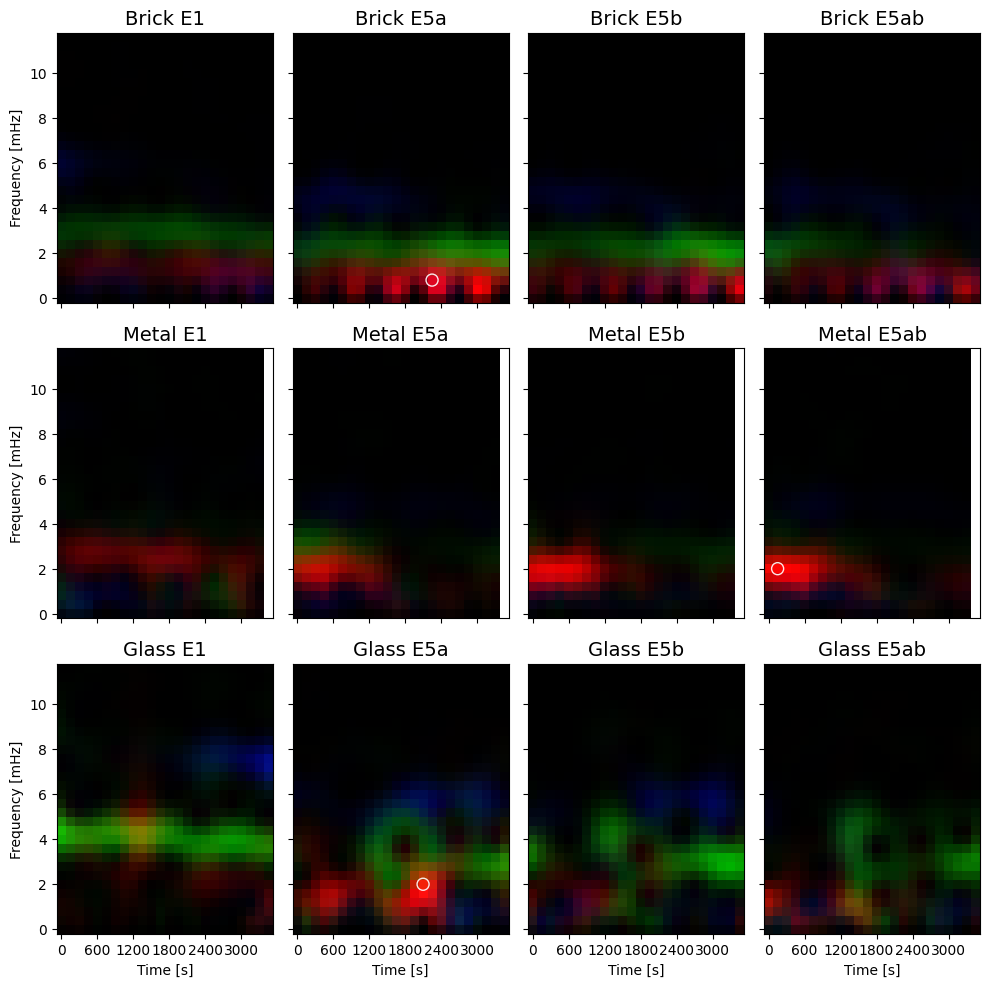

/tmp/ipykernel_14583/4149442221.py:156: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[-1, 0].set_yticklabels(adjusted_yticks)
/tmp/ipykernel_14583/4149442221.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[-1,-1].set_xticklabels(new_xticks)


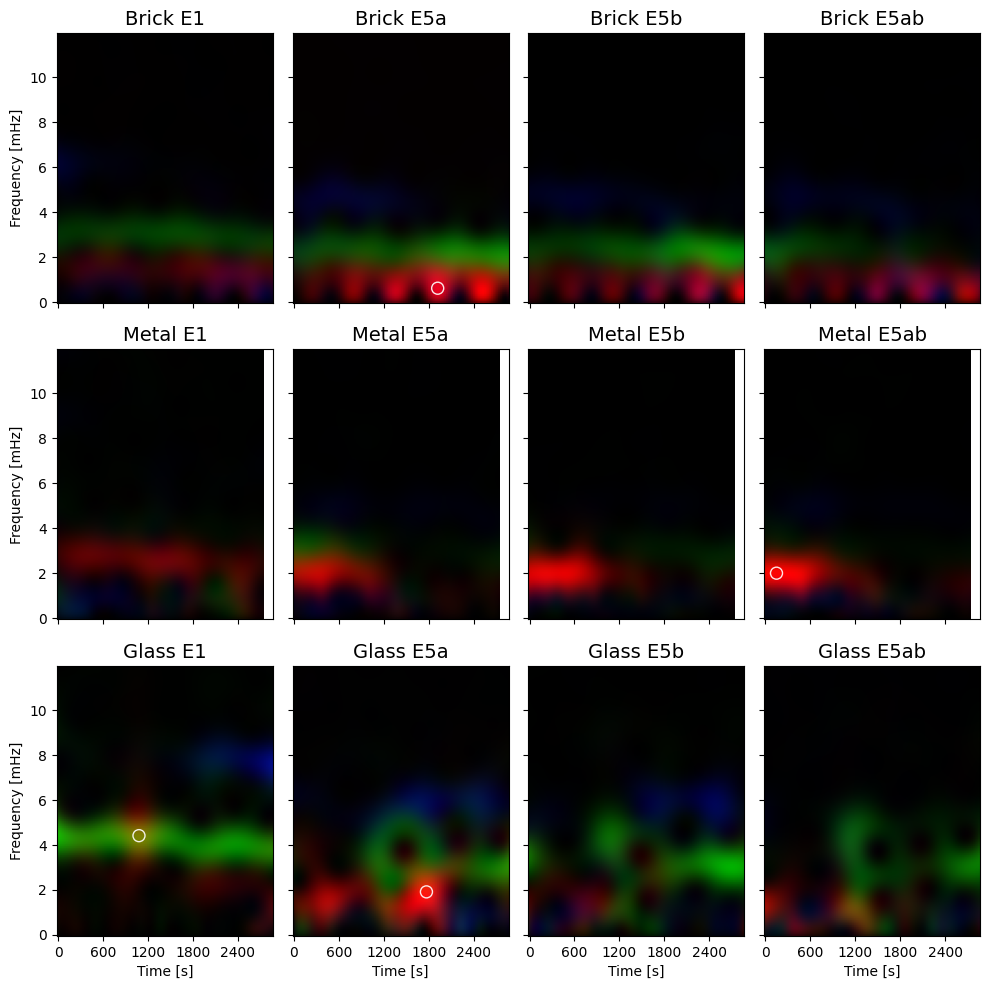

In [89]:
filename = f''

filename += 'spectrogram_'

if NORMALIZE_EVERYTHING:
    filename += 'everything_normalized_'
elif NORMALIZE_PER_IMAGE:
    filename += 'normalized_per_image_'
elif NORMALIZE_PER_MATERIAL:
    filename += 'normalized_per_material_'

if use == 'G':
    filename += 'RGB_'
    filename += 'GPS_'
elif use == 'E':
    if USE_DISTANCE_IMAGES:
        filename += 'RGB_'
    else:
        filename += 'CMYK_'
    filename += 'Galileo_'

if USE_DISTANCE_IMAGES:
    filename += 'distance_dependency'
else:
    filename += 'frequency_dependency'


if USE_DISTANCE_IMAGES:
    if use == 'G':
        fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

        images = {
            'brick': [rgb_image_L1_brick, rgb_image_L2_brick, rgb_image_L5_brick],
            'metal': [rgb_image_L1_metal, rgb_image_L2_metal, rgb_image_L5_metal],
            'glass': [rgb_image_L1_glass, rgb_image_L2_glass, rgb_image_L5_glass]
        }

        for i, (material, material_images) in enumerate(images.items()):
            for j, image in enumerate(material_images):
                plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {frequencies[j]}',find_max=True)
        
        for i in range(ax.shape[1]):
            ax[ax.shape[0]-1,i].set_xlabel('Time [s]')
            pass

        for i in range(ax.shape[0]):
            ax[i,0].set_ylabel('Frequency [mHz]')
            pass

        ax[-1, 0].yaxis.set_major_locator(MaxNLocator(nbins=7))
        adjusted_yticks = np.arange(-2,16,2)
        ax[-1, 0].set_yticklabels(adjusted_yticks)
        ax[-1, 0].xaxis.set_major_locator(MaxNLocator(nbins=6))
        wrong_xticks = ax[-1,-1].get_xticks()
        len_of_t = 3600
        new_xticks = np.linspace(-600,3600,8).astype(int)
        ax[-1,-1].set_xticklabels(new_xticks)

        plt.tight_layout()
        plt.savefig(f'../figs/distance_correlation/stacked_images/{filename}.png')
        plt.savefig(f'../figs/distance_correlation/stacked_images/{filename}.pdf')
        plt.show()


        fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

        images = {
            'brick': [rgb_image_L1_brick, rgb_image_L2_brick, rgb_image_L5_brick],
            'metal': [rgb_image_L1_metal, rgb_image_L2_metal, rgb_image_L5_metal],
            'glass': [rgb_image_L1_glass, rgb_image_L2_glass, rgb_image_L5_glass]
        }

        for i, (material, material_images) in enumerate(images.items()):
            for j, image in enumerate(material_images):
                plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {frequencies[j]}',find_max=True, interpolate=True)
        
        for i in range(ax.shape[1]):
            ax[ax.shape[0]-1,i].set_xlabel('Time [s]')
            pass

        for i in range(ax.shape[0]):
            ax[i,0].set_ylabel('Frequency [mHz]')
            pass

        ax[-1, 0].yaxis.set_major_locator(MaxNLocator(nbins=7))
        adjusted_yticks = np.arange(-2,16,2)
        ax[-1, 0].set_yticklabels(adjusted_yticks)
        ax[-1, 0].xaxis.set_major_locator(MaxNLocator(nbins=6))
        wrong_xticks = ax[-1,-1].get_xticks()
        len_of_t = 3600
        new_xticks = np.linspace(-600,3600,8).astype(int)
        ax[-1,-1].set_xticklabels(new_xticks)

        plt.tight_layout()
        plt.savefig(f'../figs/distance_correlation/stacked_images/smoothed_{filename}.png')
        plt.savefig(f'../figs/distance_correlation/stacked_images/smoothed_{filename}.pdf')
        plt.show()
    elif use == 'E':
        fig, ax = plt.subplots(3, 4, figsize=(10, 10), sharex=True, sharey=True)

        images = {
            'brick': [rgb_image_E1_brick, rgb_image_E5a_brick, rgb_image_E5b_brick, rgb_image_E5ab_brick],
            'metal': [rgb_image_E1_metal, rgb_image_E5a_metal, rgb_image_E5b_metal, rgb_image_E5ab_metal],
            'glass': [rgb_image_E1_glass, rgb_image_E5a_glass, rgb_image_E5b_glass, rgb_image_E5ab_glass]
        }

        for i, (material, material_images) in enumerate(images.items()):
            for j, image in enumerate(material_images):
                plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {frequencies[j]}',find_max=True)
        
        for i in range(ax.shape[1]):
            ax[ax.shape[0]-1,i].set_xlabel('Time [s]')
            pass

        for i in range(ax.shape[0]):
            ax[i,0].set_ylabel('Frequency [mHz]')
            pass

        ax[-1, 0].yaxis.set_major_locator(MaxNLocator(nbins=7))
        adjusted_yticks = np.arange(-2,16,2)
        ax[-1, 0].set_yticklabels(adjusted_yticks)
        ax[-1, 0].xaxis.set_major_locator(MaxNLocator(nbins=6))
        wrong_xticks = ax[-1,-1].get_xticks()
        len_of_t = 3600
        new_xticks = np.linspace(-600,3600,8).astype(int)
        ax[-1,-1].set_xticklabels(new_xticks)

        plt.tight_layout()
        plt.savefig(f'../figs/distance_correlation/stacked_images/{filename}.png')
        plt.savefig(f'../figs/distance_correlation/stacked_images/{filename}.pdf')
        plt.show()


        fig, ax = plt.subplots(3, 4, figsize=(10, 10), sharex=True, sharey=True)

        images = {
            'brick': [rgb_image_E1_brick, rgb_image_E5a_brick, rgb_image_E5b_brick, rgb_image_E5ab_brick],
            'metal': [rgb_image_E1_metal, rgb_image_E5a_metal, rgb_image_E5b_metal, rgb_image_E5ab_metal],
            'glass': [rgb_image_E1_glass, rgb_image_E5a_glass, rgb_image_E5b_glass, rgb_image_E5ab_glass]
        }

        for i, (material, material_images) in enumerate(images.items()):
            for j, image in enumerate(material_images):
                plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {frequencies[j]}',find_max=True, interpolate=True)
        
        for i in range(ax.shape[1]):
            ax[ax.shape[0]-1,i].set_xlabel('Time [s]')
            pass

        for i in range(ax.shape[0]):
            ax[i,0].set_ylabel('Frequency [mHz]')
            pass

        ax[-1, 0].yaxis.set_major_locator(MaxNLocator(nbins=7))
        adjusted_yticks = np.arange(-2,16,2)
        ax[-1, 0].set_yticklabels(adjusted_yticks)
        ax[-1, 0].xaxis.set_major_locator(MaxNLocator(nbins=6))
        wrong_xticks = ax[-1,-1].get_xticks()
        len_of_t = 3600
        new_xticks = np.linspace(-600,3600,8).astype(int)
        ax[-1,-1].set_xticklabels(new_xticks)

        plt.tight_layout()
        plt.savefig(f'../figs/distance_correlation/stacked_images/smoothed_{filename}.png')
        plt.savefig(f'../figs/distance_correlation/stacked_images/smoothed_{filename}.pdf')
        plt.show()
else:
    if use == 'G':
        fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

        images = {
            'brick': [rgb_image_brick_short, rgb_image_brick_medium, rgb_image_brick_long],
            'metal': [rgb_image_metal_short, rgb_image_metal_medium, rgb_image_metal_long],
            'glass': [rgb_image_glass_short, rgb_image_glass_medium, rgb_image_glass_long]
        }

        for i, (material, material_images) in enumerate(images.items()):
            for j, image in enumerate(material_images):
                plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {distances[j]}',find_max=True)

        ax[-1, 0].yaxis.set_major_locator(MaxNLocator(nbins=7))
        adjusted_yticks = np.arange(-2,16,2)
        ax[-1, 0].set_yticklabels(adjusted_yticks)
        ax[-1, 0].xaxis.set_major_locator(MaxNLocator(nbins=6))
        wrong_xticks = ax[-1,-1].get_xticks()
        len_of_t = 3600
        new_xticks = np.linspace(-600,3600,8).astype(int)
        ax[-1,-1].set_xticklabels(new_xticks)

        plt.tight_layout()
        plt.show()


        fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

        images = {
            'brick': [rgb_image_brick_short, rgb_image_brick_medium, rgb_image_brick_long],
            'metal': [rgb_image_metal_short, rgb_image_metal_medium, rgb_image_metal_long],
            'glass': [rgb_image_glass_short, rgb_image_glass_medium, rgb_image_glass_long]
        }

        for i, (material, material_images) in enumerate(images.items()):
            for j, image in enumerate(material_images):
                plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {distances[j]}',find_max=True, interpolate=True)

        ax[-1, 0].yaxis.set_major_locator(MaxNLocator(nbins=7))
        adjusted_yticks = np.arange(-2,16,2)
        ax[-1, 0].set_yticklabels(adjusted_yticks)
        ax[-1, 0].xaxis.set_major_locator(MaxNLocator(nbins=6))
        wrong_xticks = ax[-1,-1].get_xticks()
        len_of_t = 3600
        new_xticks = np.linspace(-600,3600,8).astype(int)
        ax[-1,-1].set_xticklabels(new_xticks)

        plt.tight_layout()
        plt.show()
    elif use == 'E':
        fig, ax = plt.subplots(3, 3, figsize=(5, 5), sharex=True, sharey=True)

        images = {
            'brick': [cmyk_image_brick_short, cmyk_image_brick_medium, cmyk_image_brick_long],
            'metal': [cmyk_image_metal_short, cmyk_image_metal_medium, cmyk_image_metal_long],
            'glass': [cmyk_image_glass_short, cmyk_image_glass_medium, cmyk_image_glass_long]
        }

        for i, (material, material_images) in enumerate(images.items()):
            for j, image in enumerate(material_images):
                plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {distances[j]}',find_max=True)

        ax[-1, 0].yaxis.set_major_locator(MaxNLocator(nbins=7))
        adjusted_yticks = np.arange(-2,16,2)
        ax[-1, 0].set_yticklabels(adjusted_yticks)
        ax[-1, 0].xaxis.set_major_locator(MaxNLocator(nbins=6))
        wrong_xticks = ax[-1,-1].get_xticks()
        len_of_t = 3600
        new_xticks = np.linspace(-600,3600,8).astype(int)
        ax[-1,-1].set_xticklabels(new_xticks)

        plt.tight_layout()
        plt.show()


        fig, ax = plt.subplots(3, 3, figsize=(5, 5), sharex=True, sharey=True)

        images = {
            'brick': [cmyk_image_brick_short, cmyk_image_brick_medium, cmyk_image_brick_long],
            'metal': [cmyk_image_metal_short, cmyk_image_metal_medium, cmyk_image_metal_long],
            'glass': [cmyk_image_glass_short, cmyk_image_glass_medium, cmyk_image_glass_long]
        }

        for i, (material, material_images) in enumerate(images.items()):
            for j, image in enumerate(material_images):
                plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {distances[j]}',find_max=True, interpolate=True)

        ax[-1, 0].yaxis.set_major_locator(MaxNLocator(nbins=7))
        adjusted_yticks = np.arange(-2,16,2)
        ax[-1, 0].set_yticklabels(adjusted_yticks)
        ax[-1, 0].xaxis.set_major_locator(MaxNLocator(nbins=6))
        wrong_xticks = ax[-1,-1].get_xticks()
        len_of_t = 3600
        new_xticks = np.linspace(-600,3600,8).astype(int)
        ax[-1,-1].set_xticklabels(new_xticks)

        plt.tight_layout()
        plt.show()

